In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import sklearn
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures#数据预处理，标准化
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

In [2]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [3]:
## 创建模拟数据
np.random.seed(100)
np.set_printoptions(linewidth=1000, suppress=True)#显示方式设置，每行的字符数用于插入换行符，是否使用科学计数法
N = 10
x = np.linspace(0, 6, N) + np.random.randn(N)
y = 1.8*x**3 + x**2 - 14*x - 7 + np.random.randn(N)
## 将其设置为矩阵
x.shape = -1, 1
y.shape = -1, 1

In [4]:
## RidgeCV和Ridge的区别是：前者可以进行交叉验证
models = [
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=False)),
            ('Linear', LinearRegression(fit_intercept=False))
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=False)),
            # alpha给定的是Ridge算法中，L2正则项的权重值，也就是ppt中的兰姆达
            # alphas是给定CV交叉验证过程中，Ridge算法的alpha参数值的取值的范围
            ('Linear', RidgeCV(alphas=np.logspace(-3,2,50), fit_intercept=False))
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=False)),
            ('Linear', LassoCV(alphas=np.logspace(0,1,10), fit_intercept=False))
        ]),
    Pipeline([
            ('Poly', PolynomialFeatures(include_bias=False)),
            # la_ratio：给定EN算法中L1正则项在整个惩罚项中的比例，这里给定的是一个列表；
            # 表示的是在CV交叉验证的过程中，EN算法L1正则项的权重比例的可选值的范围
            ('Linear', ElasticNetCV(alphas=np.logspace(0,1,10), l1_ratio=[.1, .5, .7, .9, .95, 1], fit_intercept=False))
        ])
]

1阶，系数为： [30.38156963]
5阶，系数为： [-19.20808111  -0.21353395   3.43106275  -0.38668311   0.02765531]
9阶，系数为： [-109.41783291  187.72709922 -113.70069799   -4.58285718   36.05537178  -17.39656098    3.82839965   -0.41298251    0.01765462]


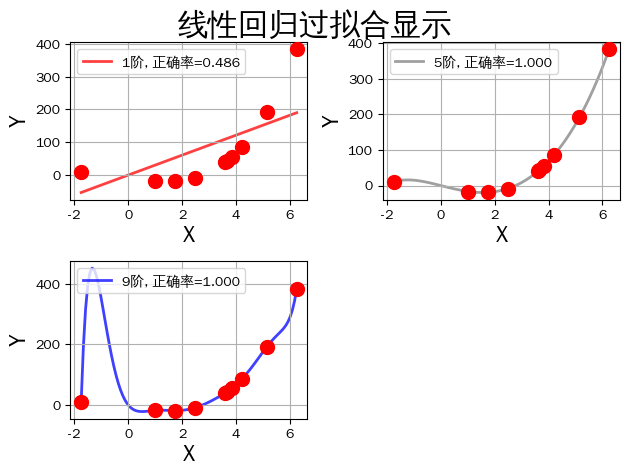

In [6]:
## 线性模型过拟合图形识别
plt.figure(facecolor='w')
degree = np.arange(1,N,4) # 阶
dm = degree.size
colors = [] # 颜色
for c in np.linspace(16711680, 255, dm):
    colors.append('#%06x' % int(c))

model = models[0]
for i,d in enumerate(degree):
    plt.subplot(int(np.ceil(dm/2.0)),2,i+1)
    plt.plot(x, y, 'ro', ms=10, zorder=N)

    # 设置阶数
    model.set_params(Poly__degree=d)
    # 模型训练
    model.fit(x, y.ravel())
    
    lin = model.get_params('Linear')['Linear']
    output = u'%d阶，系数为：' % (d)
    # 判断lin对象中是否有对应的属性
    if hasattr(lin, 'alpha_'):
        idx = output.find(u'系数')
        output = output[:idx] + (u'alpha=%.6f, ' % lin.alpha_) + output[idx:]
    if hasattr(lin, 'l1_ratio_'):
        idx = output.find(u'系数')
        output = output[:idx] + (u'l1_ratio=%.6f, ' % lin.l1_ratio_) + output[idx:]
    print (output, lin.coef_.ravel())
    
    x_hat = np.linspace(x.min(), x.max(), num=100) ## 产生模拟数据
    x_hat.shape = -1,1
    y_hat = model.predict(x_hat)
    s = model.score(x, y)
    
    z = N - 1 if (d == 2) else 0
    label = u'%d阶, 正确率=%.3f' % (d,s)
    plt.plot(x_hat, y_hat, color=colors[i], lw=2, alpha=0.75, label=label, zorder=z)
    
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)

plt.tight_layout(rect=(0,0,1,0.95))
plt.suptitle(u'线性回归过拟合显示', fontsize=22)
plt.show()

线性回归:1阶，系数为： [30.38156963]
线性回归:3阶，系数为： [-13.79947972  -0.22559096   1.96459255]
线性回归:5阶，系数为： [-19.20808111  -0.21353395   3.43106275  -0.38668311   0.02765531]
线性回归:7阶，系数为： [-22.90452624   2.55148389   3.97385058  -1.21202144   0.24964178  -0.02260922   0.0007314 ]
线性回归:9阶，系数为： [-109.41783291  187.72709922 -113.70069799   -4.58285718   36.05537178  -17.39656098    3.82839965   -0.41298251    0.01765462]
Ridge回归:1阶，alpha=2.329952, 系数为： [29.87629065]
Ridge回归:3阶，alpha=0.719686, 系数为： [-12.98191422  -0.50844765   1.98772916]
Ridge回归:5阶，alpha=0.026827, 系数为： [-18.76655299  -0.28947771   3.32509764  -0.35027493   0.02456046]
Ridge回归:7阶，alpha=0.016768, 系数为： [-17.34640888  -3.48657706   4.33150776   0.39729205  -0.45104323   0.08994496  -0.00562272]
Ridge回归:9阶，alpha=5.963623, 系数为： [-2.2521578  -2.27937783 -1.70299005 -1.0348803   0.85755012  0.37020601 -0.26024292  0.04709033 -0.00277978]
Lasso回归:1阶，alpha=1.000000, 系数为： [30.30898284]
Lasso回归:3阶，alpha=1.668101, 系数为： [-12.9336067   -0.38178368   

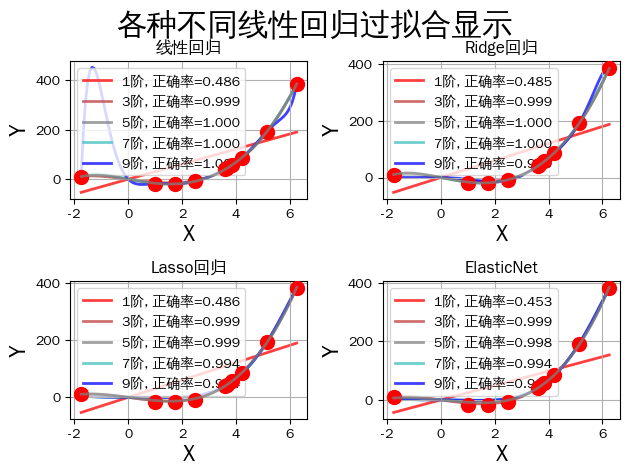

In [8]:
## 线性回归、Lasso回归、Ridge回归、ElasticNet比较
plt.figure(facecolor='w')
degree = np.arange(1,N, 2) # 阶， 多项式扩展允许给定的阶数
dm = degree.size
colors = [] # 颜色
for c in np.linspace(16711680, 255, dm):
    colors.append('#%06x' % int(c))
titles = [u'线性回归', u'Ridge回归', u'Lasso回归', u'ElasticNet']

for t in range(4):
    model = models[t]#选择了模型--具体的pipeline(线性、Lasso、Ridge、EN)
    plt.subplot(2,2,t+1) # 选择具体的子图
    plt.plot(x, y, 'ro', ms=10, zorder=N) # 在子图中画原始数据点； zorder：图像显示在第几层

    # 遍历不同的多项式的阶，看不同阶的情况下，模型的效果
    for i,d in enumerate(degree):
        # 设置阶数(多项式)
        model.set_params(Poly__degree=d)
        # 模型训练
        model.fit(x, y.ravel())

        # 获取得到具体的算法模型
        # model.get_params()方法返回的其实是一个dict对象，后面的Linear其实是dict对应的key
        # 也是我们在定义Pipeline的时候给定的一个名称值
        lin = model.get_params()['Linear']
        # 打印数据
        output = u'%s:%d阶，系数为：' % (titles[t],d)
        # 判断lin对象中是否有对应的属性
        if hasattr(lin, 'alpha_'): # 判断lin这个模型中是否有alpha_这个属性
            idx = output.find(u'系数')
            output = output[:idx] + (u'alpha=%.6f, ' % lin.alpha_) + output[idx:]
        if hasattr(lin, 'l1_ratio_'): # 判断lin这个模型中是否有l1_ratio_这个属性
            idx = output.find(u'系数')
            output = output[:idx] + (u'l1_ratio=%.6f, ' % lin.l1_ratio_) + output[idx:]
        # line.coef_：获取线性模型的参数列表，也就是我们ppt中的theta值，ravel()将结果转换为1维数据
        print (output, lin.coef_.ravel())

        # 产生模拟数据
        x_hat = np.linspace(x.min(), x.max(), num=100) ## 产生模拟数据
        x_hat.shape = -1,1
        # 数据预测
        y_hat = model.predict(x_hat)
        # 计算准确率
        s = model.score(x, y)

        # 当d等于5的时候，设置为N-1层，其它设置0层；将d=5的这条线凸显出来
        z = N + 1 if (d == 5) else 0
        label = u'%d阶, 正确率=%.3f' % (d,s)
        plt.plot(x_hat, y_hat, color=colors[i], lw=2, alpha=0.75, label=label, zorder=z)
    
    plt.legend(loc = 'upper left')
    plt.grid(True)
    plt.title(titles[t])
    plt.xlabel('X', fontsize=16)
    plt.ylabel('Y', fontsize=16)
plt.tight_layout(rect=(0,0,1,0.95))
plt.suptitle(u'各种不同线性回归过拟合显示', fontsize=22)
plt.show()